**Universidad Internacional de La Rioja (UNIR) - Máster Universitario en Inteligencia Artificial - Procesamiento del Lenguaje Natural** 

***
Datos del alumno (Nombre y Apellidos): Gianmarco Holgado Murga

Fecha: 18/04/2025
***

<span style="font-size: 20pt; font-weight: bold; color: #0098cd;">Trabajo: Named-Entity Recognition</span>

**Objetivos** 

Con esta actividad se tratará de que el alumno se familiarice con el manejo de la librería spacy, así como con los conceptos básicos de manejo de las técnicas NER

**Descripción**

En esta actividad debes procesar de forma automática un texto en lenguaje natural para detectar características básicas en el mismo, y para identificar y etiquetar las ocurrencias de conceptos como localización, moneda, empresas, etc.

En la primera parte del ejercicio se proporciona un código fuente a través del cual se lee un archivo de texto y se realiza un preprocesado del mismo. En esta parte el alumno tan sólo debe ejecutar y entender el código proporcionado.

En la segunda parte del ejercicio se plantean una serie de preguntas que deben ser respondidas por el alumno. Cada pregunta deberá responderse con un fragmento de código fuente que esté acompañado de la explicación correspondiente. Para elaborar el código solicitado, el alumno deberá visitar la documentación de la librería spacy, cuyos enlaces se proporcionarán donde corresponda.

## Parte 1: carga y preprocesamiento del texto a analizar

In [1]:

import pathlib
import chardet
import csv
import io
import spacy
import es_core_news_md
from collections import Counter
from spacy import displacy
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nlp = es_core_news_md.load()

### Carga de datos

**Pasos realizados:**

* Primero se verificó la ruta del archivo con `pathlib`, para saber asegurarnos de que exista.
* Luego usamos `chardet` para poder detectar el encoding que tiene el archivo csv, el cual nos dio como resultado que es utf-8
* Al cargar el documento no detectaba **utf-8**, en lugar de ello se cargaba con **latin-1**, sin embargo, no resolvía el problema a fondo de los caracteres especiales, deduciendo que era un error con el **BOM** que son unos bytes que agrega excel a los archivos csv, debido a ello se uso la librería `csv` para guardar línea a línea el documento en memoría, ya que esta librería puede usar el encoding **utf-8-sig** que excluye el BOM del documento. Estando en memoria el archivo se uso la librería `io` para simular que es un archivo y `pandas` lo pueda leer.
* Solo se obtuvieron los datos de las columnas que vamos a necesitar ``['CONTENIDO A ANALIZAR', 'INTENSIDAD']``, esto mejoro enormente la eficiencia del programa al consumir menos recursos computacionales.

In [3]:
# Verifico si el archivo existe
ruta_csv = pathlib.Path("../../../../Users/User/Downloads/02Dataset_sin_procesar.csv")
if ruta_csv.exists():
    print("Archivo encontrado:", ruta_csv.resolve())
else:
    print("El archivo no fue encontrado. Revisa la ruta.")

Archivo encontrado: C:\Users\User\Downloads\02Dataset_sin_procesar.csv


In [4]:
# Detecto el tipo de encoding leyendo una muestra del archivo
with open(ruta_csv, "rb") as f:
    resultado = chardet.detect(f.read(100000))  # lee 100k bytes
    print("Encoding detectado:", resultado["encoding"])

Encoding detectado: utf-8


In [5]:
# El archivo CSV es UTF-8, pero con BOM (Byte Order Mark) lo cual confunde a pandas, por eso usamos utf-8-sig de la librería csv

# Se carga el archivo completo en memoria
with open(ruta_csv, 'r', encoding='utf-8-sig', errors='ignore') as f:
    contenido = f.read()

# Se usa io para engañar a pandas que es un archivo
data = pd.read_csv(
    io.StringIO(contenido),
    sep=';',
    quoting=csv.QUOTE_MINIMAL,                      # manejo correcto de las comillas
    on_bad_lines='skip',                            # salta líneas mal formateadas
    usecols=['CONTENIDO A ANALIZAR', 'INTENSIDAD', 'TIPO DE MENSAJE'],# solo las columnas necesarias para disminuir la carga computacional
    #nrows=10000
)

del contenido

C:\Users\User\AppData\Local\Temp\ipykernel_2576\1166581041.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


### Limpieza de datos

In [6]:
# Cantidad total de registros
total_inicial = len(data)
print(f"Total de filas originales: {total_inicial}")

# Se elimina los nulos
antes_nulos = len(data)
data = data.dropna(subset=['CONTENIDO A ANALIZAR', 'INTENSIDAD', 'TIPO DE MENSAJE'])
print(f"Filas eliminadas por nulos: {antes_nulos - len(data)}")

# Se elimina espacios vacíos o espacios en blanco
antes_vacios = len(data)
data = data[
    data['CONTENIDO A ANALIZAR'].str.strip().astype(bool) &
    data['TIPO DE MENSAJE'].str.strip().astype(bool)
]
print(f"Filas eliminadas por contenido vacío o solo espacios: {antes_vacios - len(data)}")

# Convierto intensidad a numérico y eliminar no numéricos
antes_intensidad = len(data)
data['INTENSIDAD'] = pd.to_numeric(data['INTENSIDAD'], errors='coerce')
data = data.dropna(subset=['INTENSIDAD'])
data['INTENSIDAD'] = data['INTENSIDAD'].astype(int)
print(f"Filas eliminadas por intensidad no numérica: {antes_intensidad - len(data)}")

# Se normaliza el tipo de mensaje
data['TIPO DE MENSAJE'] = data['TIPO DE MENSAJE'].str.strip().str.lower()

# Se elimina los duplicados
antes_duplicados = len(data)
data = data.drop_duplicates(subset=['CONTENIDO A ANALIZAR', 'INTENSIDAD', 'TIPO DE MENSAJE'])
print(f"Filas eliminadas por duplicados: {antes_duplicados - len(data)}")

# Resultado final final despues de la limpieza
print(f"Filas finales después de limpiar: {len(data)}")


Total de filas originales: 574915
Filas eliminadas por nulos: 274
Filas eliminadas por contenido vacío o solo espacios: 1
Filas eliminadas por intensidad no numérica: 3
Filas eliminadas por duplicados: 68717
Filas finales después de limpiar: 505920


In [7]:
# Se imprime cuanta memoria ram voy usando
def bytes_a_mb(bytes):
    return bytes / 1024 / 1024

print("Uso de memoria en MB por columna:")
print(data.memory_usage(deep=True).apply(bytes_a_mb))

Uso de memoria en MB por columna:
Index                     3.859863
TIPO DE MENSAJE          28.488255
CONTENIDO A ANALIZAR    891.387621
INTENSIDAD                3.859863
dtype: float64


# Parte 2: Preguntas

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 1.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Cuántos registros contiene el corpus?</span>

In [8]:
# Incluye aquí el código generado para poder responder a tu pregunta
total_registros = len(data)
print(f"El corpus contiene {total_registros} registros.")

El corpus contiene 505920 registros.


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>

* `len(data)` devuelve el número de filas que tiene el DataFrame, es decir, el total de registros que contiene el corpus en su estado actual.

* El corpus original tenía un total de **574,915 registros**. Sin embargo, se realizaron varias tareas de limpieza y optimización para reducir el consumo de recursos computacionales y mejorar la calidad de los datos. Como los siguientes

  1. **Detección y corrección del encoding**:
     El archivo contenía caracteres especiales que dificultaban su correcta lectura. Con la ayuda de la librería `chardet`, se detectó que el archivo estaba codificado en **UTF-8 con BOM (Byte Order Mark)**.
     Aunque `pandas` tiene soporte para UTF-8, no maneja bien el BOM, lo que puede provocar errores o caracteres mal interpretados. Se probó con `latin-1`, pero aún se presentaban caracteres no válidos. Finalmente, se utilizó el encoding **utf-8-sig** de la librería `csv` junto con la librería `io` para simular que el contenido leído en memoria era un archivo. Esto permitió cargar el archivo correctamente, evitando problemas de codificación. Este vendría ser el [codigo de carga de datos](#carga-de-datos).

  2. **Eliminación de valores nulos**:
     Se eliminaron **274 filas** que contenían valores nulos.

  3. **Filtrado de contenidos vacíos o con solo espacios**:
     Se identificó y eliminó **1 fila** cuyo contenido era vacío o contenía únicamente espacios en blanco o saltos de línea.

  4. **Conversión y limpieza de la columna INTENSIDAD**:
     Se detectaron **3 filas** donde la intensidad no era numérica (vacía o con caracteres no válidos). Asi que se eliminaron

  5. **Eliminación de duplicados**:
     Se eliminaron **68717 registros duplicados**, es decir, mensajes que se repetían exactamente con la misma intensidad.
  6. Todo esto se realizó en el [codigo de limpieza de datos](#Limpieza-de-datos)

* Como resultado de estas acciones, el corpus quedó finalmente con un total de **505920 registros** los cuales tienen la calidad asegurada para los siguientes análisis

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 2.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Cuántas palabras totales hay en los comentarios del corpus?</span>

In [9]:
# Procesamiento de los datos en nlp
comentarios = data[data['TIPO DE MENSAJE'] == 'comentario']
docs = list(tqdm(nlp.pipe(comentarios['CONTENIDO A ANALIZAR'], batch_size=100), total=len(comentarios)))

100%|██████████| 302980/302980 [22:46<00:00, 221.72it/s]


In [10]:
# Incluye aquí el código generado para poder responder a tu pregunta
total_palabras = sum(len([token for token in doc if token.is_alpha]) for doc in docs)
print(f"El corpus contiene {total_palabras} palabras.")

El corpus contiene 14270044 palabras.


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>

* Para calcular la cantidad de palabras presentes en los comentarios del corpus, se ha utilizado la librería `spaCy` para procesar los textos que habíamos limpiado, pero, solo procesamos los comentarios, ya que todas las preguntas son entorno a esta información, ahorrando recursos computacionales. Este procesamiento se realizó con `nlp-pipe` que es una herramienta poderosa de spaCy que realiza el procesamiento por lotes, en este caso se uso la cantidad de 100 textos en paralelos sin saturar mucho la ram. Además se uso ``tqdm`` para obtener la barra de proceso.

* El conteo de palabras se realizó filtrando los tokens que son palabras alfabéticas `token.is_alpha` para evitar contar signos de puntuación, números u otros símbolos. La suma total de estos tokens nos da el número de **14 270 044** palabras en los comentarios.


<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 3.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Cuál el número promedio de palabras en cada comentario?</span>

In [11]:
# Incluye aquí el código generado para poder responder a tu pregunta
promedio_palabras = total_palabras / len(comentarios)
print(f"El número promedio de palabras por comentario es: {promedio_palabras:.2f}")

El número promedio de palabras por comentario es: 47.10


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>

* Para calcular el número promedio de palabras por comentario, se utilizó el `total_palabras` contadas previamente en la **pregunta 2** y se dividió entre el número total de comentarios en el corpus.
* Esto nos dio el promedio de **47.10**, cabe recalcar que aca no consideramos signos de puntuación, emoticones o caracteres especiales, solo palabras.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 4.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál el número promedio de palabras en los comentarios de cada grupo?</span>

In [12]:
# Incluye aquí el código generado para poder responder a tu pregunta

# Contadore
total_palabras_odio = 0
total_palabras_no_odio = 0
conteo_odio = 0
conteo_no_odio = 0

# Se recorre cada doc para obtener la cantidad y las palabras de cada doc
for intensidad, doc in zip(comentarios['INTENSIDAD'], docs):
    num_palabras = len([token for token in doc if token.is_alpha])

    if intensidad > 0:
        total_palabras_odio += num_palabras
        conteo_odio += 1
    else:
        total_palabras_no_odio += num_palabras
        conteo_no_odio += 1

# Se calcula el promedio
promedio_odio = total_palabras_odio / conteo_odio
promedio_no_odio = total_palabras_no_odio / conteo_no_odio

print(f"Promedio de palabras en comentarios CON odio: {promedio_odio:.2f}")
print(f"Promedio de palabras en comentarios SIN odio: {promedio_no_odio:.2f}")


Promedio de palabras en comentarios CON odio: 15.85
Promedio de palabras en comentarios SIN odio: 48.16


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>

* En este codigo se junto los `docs` ya procesados con la data intensidad en un zip, esto ayuda a reducir costo computacional, ya que no estamos creando un nuevo dataframe con los docs.
* Se recorrieró cada comentario y se separo en dos grupos según la siguienet condición:

  - Si `INTENSIDAD == 0`, se contabiliza como **comentario sin odio**.
  - Si `INTENSIDAD > 0`, se contabiliza como **comentario con odio**.

* De la misma manera que el anterior solo se cuenta las palabras ignorando signos de puntuación, espacios u otros caracteres, y se suma a su grupo correspondiente. Finalmente, se calcula el promedio dividiendo el total de palabras entre el total de comentarios por grupo.
* Como observamos los comentarios con odio tienen un promedio menor de palabras que es **15.85** y los comentarios sin odio tienen **48.16**, lo nos podría llevar a la conclusión de que los comentarios con odio suelen ser mas cortos y directos que los comentarios sin odio.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 5.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál es el número promedio de oraciones en los comentarios de cada grupo?</span>

In [13]:
# Incluye aquí el código generado para poder responder a tu pregunta

total_oraciones_odio = 0
total_oraciones_no_odio = 0
conteo_odio = 0
conteo_no_odio = 0

# Se recorre cada comentario para saber la cantidad de oraciones que tienen
for intensidad, doc in zip(comentarios['INTENSIDAD'], docs):
    num_oraciones = len(list(doc.sents))  # Convertir a lista porque doc.sents es un generador

    if intensidad > 0:
        total_oraciones_odio += num_oraciones
        conteo_odio += 1
    else:
        total_oraciones_no_odio += num_oraciones
        conteo_no_odio += 1

# Se calcula promedio
promedio_oraciones_odio = total_oraciones_odio / conteo_odio
promedio_oraciones_no_odio = total_oraciones_no_odio / conteo_no_odio

print(f"Promedio de oraciones en comentarios CON odio: {promedio_oraciones_odio:.2f}")
print(f"Promedio de oraciones en comentarios SIN odio: {promedio_oraciones_no_odio:.2f}")


Promedio de oraciones en comentarios CON odio: 1.57
Promedio de oraciones en comentarios SIN odio: 2.29


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>

* Para responder esta pregunta, se utilizó el procesamiento anterior de la **pregunta 4**. Se contó el número de oraciones por comentario `len(doc.sents)` y se separaron según su grupo:

  - Comentarios sin odio: `INTENSIDAD == 0`
  - Comentarios con odio: `INTENSIDAD > 0`

* Esto nos llevo a obtener **1.57** oraciones en los comentarios con odio y **2.29** oraciones en comentarios sin odio. Lo que podría indicar que las personas que redactan textos con odio suelen tener entre 1 a 2 oraciones.


<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 6.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál es el porcentaje de comentarios que contienen entidades NER en cada grupo?</span>

In [14]:
# Incluye aquí el código generado para poder responder a tu pregunta

con_ner_odio = 0
total_odio = 0
con_ner_no_odio = 0
total_no_odio = 0

# Se recorre los comentarios para contar los que tienen entidad
for intensidad, doc in zip(comentarios['INTENSIDAD'], docs):
    tiene_ner = len(doc.ents) > 0  # True si tiene al menos una entidad

    if intensidad > 0:
        total_odio += 1
        if tiene_ner:
            con_ner_odio += 1
    else:
        total_no_odio += 1
        if tiene_ner:
            con_ner_no_odio += 1

# Se calcula los porcentajes
porcentaje_ner_odio = (con_ner_odio / total_odio) * 100
porcentaje_ner_no_odio = (con_ner_no_odio / total_no_odio) * 100

print(f"Porcentaje de comentarios CON odio que contienen entidades NER: {porcentaje_ner_odio:.2f}%")
print(f"Porcentaje de comentarios SIN odio que contienen entidades NER: {porcentaje_ner_no_odio:.2f}%")


Porcentaje de comentarios CON odio que contienen entidades NER: 37.45%
Porcentaje de comentarios SIN odio que contienen entidades NER: 48.47%


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
 
* Se utilizó `doc.ents` para obtener las entidades de cada comentario. Luego, se evaluó si cada comentario contenía al menos una entidad, separando los casos por grupo:

  - Comentarios sin odio (`INTENSIDAD == 0`)
  - Comentarios con odio (`INTENSIDAD > 0`)

* En el proceso se contaba el total de registros de cada grupo y la cantidad de registros que tenían entidades. Los resultados mostraron el porcentaje de comentarios en cada grupo que tienen al menos una entidad nombrada.
* Como resultado se obtuvo que las personas que redactan comentarios con odio tienen **37.45%** de probabilidad que nombren una entidad, y las personas que redactan sin odio tienen un **48.47%** que nombren una entidad.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 7.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál es el porcentaje de comentarios que contienen entidades NER de tipo PERSON en cada grupo?</span>

In [15]:
# Incluye aquí el código generado para poder responder a tu pregunta

con_person_odio = 0
total_odio = 0
con_person_no_odio = 0
total_no_odio = 0

# Se recorre cada comentario para contar los que tienen la entidad PER
for intensidad, doc in zip(comentarios['INTENSIDAD'], docs):
    contiene_person = any(ent.label_ == 'PER' for ent in doc.ents)

    if intensidad > 0:
        total_odio += 1
        if contiene_person:
            con_person_odio += 1
    else:
        total_no_odio += 1
        if contiene_person:
            con_person_no_odio += 1

# Se calcula porcentajes
porcentaje_person_odio = (con_person_odio / total_odio) * 100
porcentaje_person_no_odio = (con_person_no_odio / total_no_odio) * 100

print(f"Porcentaje de comentarios CON odio que mencionan personas: {porcentaje_person_odio:.2f}%")
print(f"Porcentaje de comentarios SIN odio que mencionan personas: {porcentaje_person_no_odio:.2f}%")

Porcentaje de comentarios CON odio que mencionan personas: 17.35%
Porcentaje de comentarios SIN odio que mencionan personas: 21.08%


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>

* Se utilizó `doc.ents` para saber las entidades en cada comentario, luego se uso ``ent.label_`` para saber que tipo de entidad era, se uso `any` para que me ayude a saber si almenos una entidad en cada contenido era del tipo **PERSON** o **PER** en spaCy.
* Sabiendo si el comentario tenía almenos una entidad PERSON o no, se aumentaba los contadores.
* Gracias a los contadores se pudo obtener los porcentajes de **17.35%** para los comentarios con odio y un **21.08%** para los comentarios sin odio, lo que nos permite entender que hay un 17% que se nombre a una persona cuando se este redactando un texto con odio.



<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 8.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál es el porcentaje de palabras en cada combinación posible de género y número (p.ej. masculino singular) en cada grupo?</span>

In [16]:
conteo_morph_odio = Counter()
conteo_morph_no_odio = Counter()

total_morph_odio = 0
total_morph_no_odio = 0

# Se recorre cada comentario para saber si tienen la categoria gramatical genero y numero
for intensidad, doc in zip(comentarios['INTENSIDAD'], docs):
    for token in doc:
        gender = token.morph.get("Gender")
        number = token.morph.get("Number")

        if gender and number:
            key = f"{gender[0]} {number[0]}"
            if intensidad > 0:
                conteo_morph_odio[key] += 1
                total_morph_odio += 1
            else:
                conteo_morph_no_odio[key] += 1
                total_morph_no_odio += 1

# Se calcula porcentajes
porcentajes_odio = {k: (v / total_morph_odio) * 100 for k, v in conteo_morph_odio.items()}
porcentajes_no_odio = {k: (v / total_morph_no_odio) * 100 for k, v in conteo_morph_no_odio.items()}

# Mostrar ordenado
print("Grupo: CON ODIO")
for k, v in sorted(porcentajes_odio.items(), key=lambda x: -x[1]): 
    print(f"{k}: {v:.2f}%")

print("\nGrupo: SIN ODIO")
for k, v in sorted(porcentajes_no_odio.items(), key=lambda x: -x[1]):
    print(f"{k}: {v:.2f}%")


Grupo: CON ODIO
Masc Sing: 40.27%
Fem Sing: 32.94%
Masc Plur: 18.56%
Fem Plur: 8.23%

Grupo: SIN ODIO
Masc Sing: 40.87%
Fem Sing: 32.47%
Masc Plur: 15.98%
Fem Plur: 10.68%


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
 
 * En esta proceso se uso la estructura de datos ``Counter`` que es una subclase de ``dict`` que se utiliza para contar objetos hashables. En este caso, se utilizó para contar la cantidad de palabras en cada combinación de género y número (por ejemplo masculino singular) en cada grupo de comentarios (odio y no odio).
 * Para saber el genero y el numero se uso ``token.morph.get`` que devuelve un diccionario con las características morfológicas del token, gracias a este codigo creamos una llave que contiene el género y número de cada token, realizando el conteo de cada combinación para cada grupo de (odio y no odio).
 * Teniendo los contadores de cada grupo, se calculó el porcentaje de palabras en cada combinación de género y número dividiendo el conteo de cada combinación entre el total de palabras en el grupo correspondiente y multiplicando por 100.
 * Como resultado tuvimos lo que nos muestra arriba, donde pudimos concluir que en los comentarios de odio tiene una mayor mención en palabras que son masculinas y singular, lo mismo pasa con las palabras de genero feminino y singular.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 9.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio), indica cuántas entidades de cada tipo posible se reconocen en cada uno de los grupos</span>

In [17]:
# Incluye aquí el código generado para poder responder a tu pregunta

entidades_odio = Counter()
entidades_no_odio = Counter()

# Se recorre cada comentario paracontar cada tipo de entidad
for intensidad, doc in zip(comentarios['INTENSIDAD'], docs):
    for ent in doc.ents:
        if intensidad > 0:
            entidades_odio[ent.label_] += 1
        else:
            entidades_no_odio[ent.label_] += 1

print("Entidades reconocidas en comentarios CON ODIO:")
for k, v in entidades_odio.most_common():
    print(f"{k}: {v}")

print("\nEntidades reconocidas en comentarios SIN ODIO:")
for k, v in entidades_no_odio.most_common():
    print(f"{k}: {v}")


Entidades reconocidas en comentarios CON ODIO:
PER: 1961
LOC: 1226
MISC: 963
ORG: 768

Entidades reconocidas en comentarios SIN ODIO:
LOC: 174608
PER: 137102
ORG: 53914
MISC: 53166


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>

 * Para esta pregunta se utilizó el mismo proceso que en la pregunta 6, pero en lugar de contar el porcentaje de comentarios con entidades, se contaron las entidades de cada tipo en cada grupo de comentarios (odio y no odio).
 * Para ello se uso ``ent.label_`` para obtener el tipo de entidad y se usó ``Counter`` para contar la cantidad de entidades de cada tipo en cada grupo. Además, se utilizó ``Counter.most_common()`` para ordenar las entidades de mayor a menor cantidad, obtener las tuplas con el conteo de cada tipo de entidad, cabe recalcar que esto solo funciona con valores enteros.
 * Como conclusión vemos que hay mas cantidad de entidades en comentarios sin odio, y en los comentarios con odio mencionan mas a personas y lugares.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 10.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio), extrae y muestra los 100 lemas más repetidos en los comentarios de cada grupo</span>

In [18]:
# Incluye aquí el código generado para poder responder a tu pregunta

# Contadores de lemas por grupo
lemas_odio = Counter()
lemas_no_odio = Counter()

for intensidad, doc in zip(comentarios['INTENSIDAD'], docs):
    for token in doc:
        if token.is_alpha and not token.is_stop:
            if intensidad > 0:
                lemas_odio[token.lemma_.lower()] += 1
            else:
                lemas_no_odio[token.lemma_.lower()] += 1

# Se une los 100 lemas más comunes de ambos grupos
top_lemas = set([l for l, _ in lemas_odio.most_common(100)] + [l for l, _ in lemas_no_odio.most_common(100)])

# Se crea lista de diccionarios con los conteos para crear un dataframe
lemas_data = []
for lema in top_lemas:
    lemas_data.append({
        'lema': lema,
        'con_odio': lemas_odio.get(lema, 0),
        'sin_odio': lemas_no_odio.get(lema, 0)
    })

# Se crea el DataFrame
df_lemas = pd.DataFrame(lemas_data)

# Se ordena por frecuencia en grupo con odio
df_lemas = df_lemas.sort_values(by='con_odio', ascending=False).reset_index(drop=True)

# Se muestra el top 20
df_lemas.head(20)


,lema,con_odio,sin_odio
0,mierda,758,2175
1,puta,601,836
2,gobierno,449,25422
3,asco,438,1035
4,q,381,8403
5,españa,369,21049
6,hijo,362,4058
7,país,361,17000
8,mentiroso,356,566
9,gente,337,13498


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>

* Para esta pregunta primero filtramos el contenido para obtener solo las palabras y que no sean ``stopwords``, luego se usó ``Counter`` para contar la cantidad de veces que aparece cada lema en cada grupo de comentarios (odio y no odio), el lema se obtuvo mediante `token.lemma_`.
* Luego se obtuvieron los 100 lemas más repetidos para ambos grupos de comentarios utilizando ``Counter.most_common(100)``. Para poder crear una lista de diccionarios y convertirla a un dataframe.
* Como vemos en los resultados las palabras que mas repiten en los comentarios de odio son insultos, lo que nos podría ayudar a identificar en un modelo de machine learning comentarios de odio.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 11.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Es posible utilizar alguna de las características extraídas en las preguntas anteriores para determinar si un mensaje contiene odio? Justifica tu respuesta con el análisis estadístico que consideres necesario.</span>

In [ ]:
# Se crea un dataframe con las características extraídas en las preguntas anteriores
df_stats = pd.DataFrame({
    'intensidad': comentarios['INTENSIDAD'].values,
    'num_palabras': [len([t for t in doc if t.is_alpha]) for doc in docs],
    'num_oraciones': [len(list(doc.sents)) for doc in docs],
    'tiene_ner': [1 if len(doc.ents) > 0 else 0 for doc in docs],
    'tiene_persona': [1 if any(ent.label_ == 'PER' for ent in doc.ents) else 0 for doc in docs]
})
# Se crea una columna tiene odio para poder realizar analisis
df_stats['tiene_odio'] = df_stats['intensidad'] > 0

top_lemas_odio = set(df_lemas['lema'].head(100))

# Variables que se van agregar a df_stats y que son mas complejas procesarlas
tiene_lema_frecuente_odio = []
num_entidades = []
entidad_tipo_counts = []
genero_numero_counts = []

for doc in docs:
    # Variable que coloca 1 si hay un lema frecuente de odio
    lemas_doc = set([token.lemma_.lower() for token in doc if token.is_alpha])
    tiene_lema_frecuente_odio.append(1 if lemas_doc & top_lemas_odio else 0)

    # Variable que cuenta el número de entidades y conteo por tipo
    num_entidades.append(len(doc.ents))
    tipo_counter = Counter([ent.label_ for ent in doc.ents])
    entidad_tipo_counts.append(tipo_counter)

    # Se coloca el porcentaje de palabras con morfología de género y número
    morf_counter = Counter()
    total_tokens = 0
    for token in doc:
        gender = token.morph.get('Gender')
        number = token.morph.get('Number')
        if gender and number:
            gender_str = gender[0].lower()
            number_str = number[0].lower()
            clave = f"{gender_str}_{number_str}"
            morf_counter[clave] += 1
            total_tokens += 1

    perc_masc_sing = morf_counter['masc_sing'] / total_tokens if total_tokens else 0
    perc_fem_sing = morf_counter['fem_sing'] / total_tokens if total_tokens else 0
    perc_masc_plur = morf_counter['masc_plur'] / total_tokens if total_tokens else 0
    perc_fem_plur = morf_counter['fem_plur'] / total_tokens if total_tokens else 0
    genero_numero_counts.append((perc_masc_sing, perc_fem_sing, perc_masc_plur, perc_fem_plur))

perc_masc_sing, perc_fem_sing, perc_masc_plur, perc_fem_plur = zip(*genero_numero_counts)

# Se agrega las nuevas variables a df_stats
df_stats['tiene_lema_frecuente_odio'] = tiene_lema_frecuente_odio
df_stats['num_entidades'] = num_entidades
df_stats['perc_masc_sing'] = perc_masc_sing
df_stats['perc_fem_sing'] = perc_fem_sing
df_stats['perc_masc_plur'] = perc_masc_plur
df_stats['perc_fem_plur'] = perc_fem_plur
df_stats['num_PERSON'] = [d.get('PER', 0) for d in entidad_tipo_counts]
df_stats['num_LOC'] = [d.get('LOC', 0) for d in entidad_tipo_counts]
df_stats['num_ORG'] = [d.get('ORG', 0) for d in entidad_tipo_counts]

# Se agrupa los datos por la intensidad
grupo_odio = df_stats[df_stats['intensidad'] > 0]
grupo_no_odio = df_stats[df_stats['intensidad'] == 0]

In [20]:
df_stats

,intensidad,num_palabras,num_oraciones,tiene_ner,tiene_persona,tiene_odio,tiene_lema_frecuente_odio,num_entidades,perc_masc_sing,perc_fem_sing,perc_masc_plur,perc_fem_plur,num_PERSON,num_LOC,num_ORG
0,3,25,2,1,1,True,1,1,0.500000,0.333333,0.166667,0.000000,1,0,0
1,0,195,9,1,1,False,1,5,0.739583,0.166667,0.083333,0.010417,2,1,1
2,3,127,7,1,1,True,1,3,0.500000,0.403846,0.038462,0.057692,1,1,1
3,3,19,3,0,0,True,1,0,0.714286,0.142857,0.142857,0.000000,0,0,0
4,3,147,6,1,0,True,1,4,0.526316,0.263158,0.157895,0.052632,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302975,4,17,2,0,0,True,1,0,0.600000,0.100000,0.000000,0.300000,0,0,0
302976,4,24,3,0,0,True,1,0,0.500000,0.000000,0.416667,0.083333,0,0,0
302977,4,28,4,0,0,True,1,0,0.428571,0.357143,0.071429,0.142857,0,0,0
302978,4,13,2,0,0,True,1,0,0.500000,0.250000,0.250000,0.000000,0,0,0


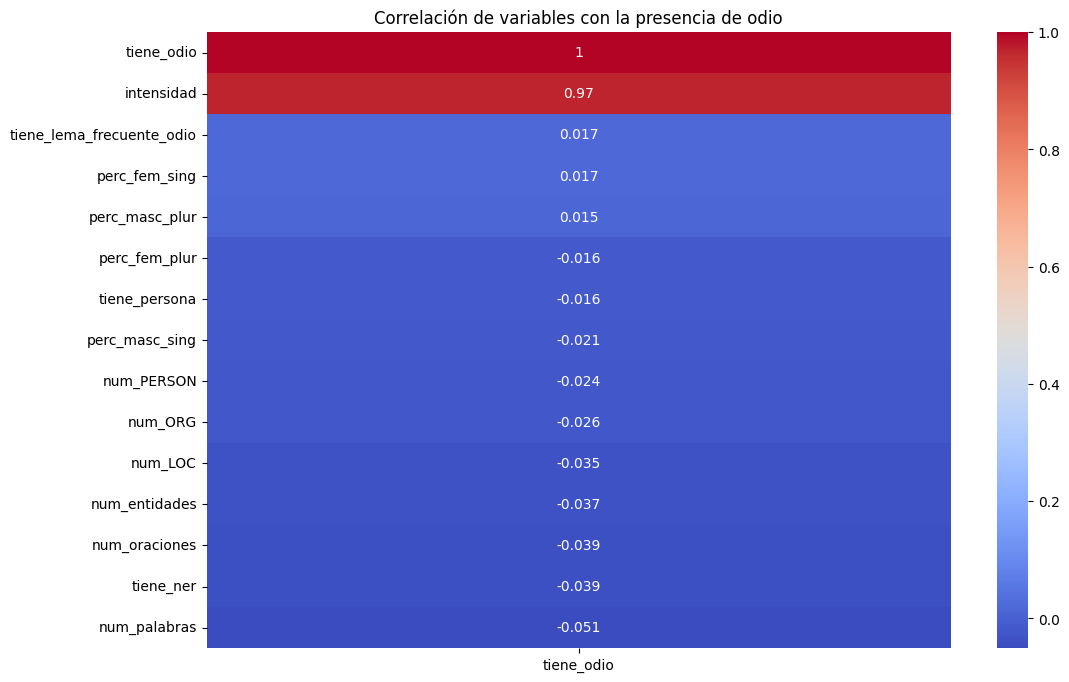

In [21]:
# Mapa de calor que nos ayuda a saber la correlación
correlation = df_stats.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation[['tiene_odio']].sort_values(by='tiene_odio', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlación de variables con la presencia de odio")
plt.show()

In [22]:
# Variables a analizar (exceptuamos las categóricas y la target)
vars_numericas = [
    'intensidad', 'num_palabras', 'num_oraciones', 'tiene_ner',
    'tiene_persona', 'tiene_lema_frecuente_odio', 'num_entidades',
    'perc_masc_sing', 'perc_fem_sing', 'perc_masc_plur',
    'perc_fem_plur', 'num_PERSON', 'num_LOC', 'num_ORG'
]

resultados_ttest = []

for var in vars_numericas:
    stat, p = ttest_ind(grupo_odio[var], grupo_no_odio[var], equal_var=False)
    media_odio = grupo_odio[var].mean()
    media_no_odio = grupo_no_odio[var].mean()
    resultados_ttest.append({
        'Variable': var,
        'Media con odio': media_odio,
        'Media sin odio': media_no_odio,
        'T-stat': stat,
        'P-valor': p
    })

df_resultados = pd.DataFrame(resultados_ttest)
df_resultados = df_resultados.sort_values(by='P-valor')

df_resultados

,Variable,Media con odio,Media sin odio,T-stat,P-valor
0,intensidad,3.692470,0.000000,399.079248,0.000000e+00
1,num_palabras,15.845784,48.162720,-114.524545,0.000000e+00
2,num_oraciones,1.570741,2.292860,-60.028248,0.000000e+00
6,num_entidades,0.493131,1.429283,-80.503105,0.000000e+00
12,num_LOC,0.122932,0.595918,-76.555202,0.000000e+00
11,num_PERSON,0.196631,0.467914,-44.972138,0.000000e+00
13,num_ORG,0.077008,0.184002,-32.730270,6.810613e-227
3,tiene_ner,0.374511,0.484695,-22.331934,5.170026e-108
7,perc_masc_sing,0.373836,0.409772,-10.512428,1.015739e-25
5,tiene_lema_frecuente_odio,0.814800,0.775572,9.891915,5.654264e-23


In [23]:
# Para poder realmente saber si las variables nos ayuda a saber si un mensaje tiene odio o no
# Se ha creado un pequeño modelo de regresion logistico

# Variables predictoras
X = df_stats[vars_numericas]
y = df_stats['tiene_odio']

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entrenamiento
model = LogisticRegression()
model.fit(X_scaled, y)

# Importancia de variables
coef_df = pd.DataFrame({
    'Variable': vars_numericas,
    'Coeficiente': model.coef_[0],
    'Importancia absoluta': np.abs(model.coef_[0])
}).sort_values(by='Importancia absoluta', ascending=False)

coef_df


,Variable,Coeficiente,Importancia absoluta
0,intensidad,8.963637,8.963637
6,num_entidades,-0.501761,0.501761
11,num_PERSON,-0.474198,0.474198
1,num_palabras,-0.384069,0.384069
12,num_LOC,-0.363832,0.363832
2,num_oraciones,-0.253008,0.253008
13,num_ORG,-0.061746,0.061746
3,tiene_ner,0.048902,0.048902
4,tiene_persona,0.047846,0.047846
5,tiene_lema_frecuente_odio,0.035583,0.035583


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>

* 🧱**Construcción de dataframe:**
  * Se contruyo un dataframe que contiene todas las características calculadas anteriormente, para ello solo se uso la data de comentarios, y se coloco las siguientes columnas:
    * tiene_odio: Se creo a partir de intensidad e indica si tiene odio o no(1 o 0).
    * tiene_lema_frecuente_odio: Coloca 1 si el comentario tiene una palabra que esta dentro del top 100 de lemas de odio.
    * perc_fem_sing, perc_masc_sing, perc_masc_plur, perc_fem_plur: Nos muestra el porcentaje de palabras que tiene genero y numero.
    * tiene_persona: Me indica si hay presencia de la entidad persona.
    * num_PERSON, num_ORG, num_LOC: Cantidad de entidad de cada tipo.
    * num_entidades: Cantidad de entidades.
    * num_oraciones: Cantidad de oraciones en cada comentario.
    * tiene_ner: Me indica si tiene entidad o no.
    * num_palabras: Cantidad de palabras en cada comentario.
* 📊**Correlación de Person:**
  * A partir de este dataframe se calculo la **correlación de Pearson** entre la variable ``tiene_odio`` y las demás.
  * Los resultados muestran que tiene una correlación fuerte con entidad, sin embargo esto no se toma en cuenta edbido a que tiene_odio proviene de la variable entidad.
  * Por el otro lado, todas las demás variables tienen una correlación entre **-0.05 y 0.02 lo que significa que tiene una relacion debil. Lo que implicaría que no serían muy efectivas para detectar mensajes con odio**
* 💉**Prueba T:**
  * Debido a que la correlación de pearson no me dio mucha información se realizó la prueba T para poder determinar si en realidad estas caracteristicas me ayudarian a detectar si un mensaje tiene odio o no.
  * Como conclusión se obtuco lo siguiente:
    * **num_palabras, num_oraciones:** obtuvo un ``valor t`` de 114 y 60 respectivamente y un ``valor p`` de 0, esto significa que al tener un valor t grande que es la distancia de las medias sumado a un valor p menor a 0.05 que nos indica que esta diferencia es real y no casualidad, nos lleva a decir que estas variables tienen potencial para ayudarnos a detectar si un mensaje tiene odio o no, ya que los mensajes mas breves son los que expresan mas odio.
    * **num_entidades:** tuvo un ``valor t`` de 80 y un ``valor p`` de 0. Esto sugiere que los mensajes con odio mencionan menos entidades (como personas, lugares u organizaciones), lo que representa otra característica útil para detectar odio.
    * **num_LOC, num_PERSON y num_ORG:** Estas dos variables tiene un ``valor p`` igual a 0 lo que significa que hay una diferencia significativa y nos lleva a decir que los mensajes de odio suelen nombrar lugares, personas y organizaciones.
    * Las demás variables si bien es cierto tienen un valor p menor a 0.05, tienen un valor t muy bajo, lo cual se **concluye que podrían no ser tan significativas en la detección de odio.**
* 🤖**Coeficiente de regresión logística:**
  * Para poder asegurarnos y concluir que variables servirian para detectar odio en los mensajes, creé un pequeño modelo de regresión logistico, que me da un indicador poderoso que es el **coeficiente**, este indicador me dice que tanto contribuye la variable a la detección del odio.
  * Podemos ver que las variables como `num_palabras`, `num_oraciones`, `num_entidades`, `num_PERSON` y `num_LOC` tienen coeficientes negativos, lo que sugiere que a mas cantidad hay menos odio, lo cual es coherente con el análisis anterior.
  * Aunque algunas variables como `tiene_ner`, `tiene_persona` y `tiene_lema_frecuente_odio` tienen coeficientes positivos, su efecto es muy pequeño comparado con `intensidad`, por lo que su utilidad individual es limitada.
  * En resumen, el modelo refuerza la idea de que los mensajes de odio tienden a ser más directos, con menos palabras y oraciones, y que la intensidad emocional del texto es una de las señales más fuertes para detectarlos.
* ✍🏻**Conclusión final:**
  * Luego de aplicar análisis de correlación, prueba T y un modelo lineal, se concluye que las variables que más aportan a la detección de mensajes de odio son:
    * `num_palabras`, `num_oraciones`: Los mensajes de odio tienden a ser más breves.
    * `num_entidades`, especialmente `num_LOC`, `num_PERSON`, `num_ORG`: Los mensajes con odio mencionan menos entidades.
    * `tiene_ner`, `tiene_lema_frecuente_odio`: Aunque con menor impacto, también ayudan a identificar odio.
    * En cambio, las demás variables no muestran una contribución significativa, por lo que podrían descartarse.


